In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import sys
import time

# Allows me to import my modules
sys.path.extend(["../../modules", "../"])

In [2]:
from problem import f, constraints, check_all_constraints, print_all_constraints

In [3]:
# GA specific functions wrapper
class GA_functions:
    def __init__(self, initial_val, encode_dna, decode_dna, mutate_dna, cross_over):
        self.initial_val = initial_val
        self.encode_dna = encode_dna
        self.decode_dna = decode_dna
        self.mutate_dna = mutate_dna
        self.cross_over = cross_over

# GA default variables wrapper
class GA_defaults:
    def __init__(self, mutation_chance, cross_over_amount, population_size, epochs, fitness_upper_bound, selection_function):
        self.mutation_chance = mutation_chance
        self.cross_over_amount = cross_over_amount
        self.population_size = population_size
        self.epochs = epochs
        self.fitness_upper_bound = fitness_upper_bound
        self.selection_function = selection_function

# Data wrapper for an instance of a member in the 'population'
class individual:
    def __init__(self, GA_funcs, dna=None, gen=None):
        # If no dna is provided, generate dna from encoding a random float; with a random sign, exponent and significand
        self.GA_funcs = GA_funcs
        self.dna = GA_funcs.encode_dna(GA_funcs.initial_val()) if dna is None else dna
        self.gen = 0 if gen is None else gen
    def get_dna(self):
        return self.dna
    def get_value(self):
        return self.GA_funcs.decode_dna(self.dna)
    def get_gen(self):
        return self.gen

# Creating a new indivual given the GA functions, individuals and a few other optional variables.
def breed_individuals(i1, i2, GA_defaults, GA_funcs, cross_over_amount=None, mutation_chance=None):
    # Set defaults if parameter not provided
    cross_over_amount = GA_defaults.cross_over_amount if cross_over_amount is None else cross_over_amount
    mutation_chance = GA_defaults.mutation_chance if mutation_chance is None else mutation_chance
    # Calculate the generation number of the offspring.
    gen1 = i1.get_gen()
    gen2 = i2.get_gen()
    next_gen = gen1+1 if gen1 > gen2 else gen2+1
    # Create the dna of the offspring
    dna1 = i1.get_dna()
    dna2 = i2.get_dna()
    new_dna = GA_funcs.mutate_dna(GA_funcs.cross_over(dna1, dna2, cross_over_amount), GA_defaults, mutation_chance)
    return individual(GA_funcs, new_dna, next_gen)

# GA parameters
'''
        fitness_func         :   The problem function which is being investigated by the metaheuristic.
        is_maximisation      :   The problem is to be maximised, as opposed to being minimised.
        GA_defaults          :   Default values of the optional parameters (which follow GA_funcs)
        
        GA_funcs             :   Other GA functions - 
                                    initial_val,
                                    encode_dna, 
                                    decode_dna, 
                                    mutate_dna, 
                                    cross_over

        population_size      :   The size of the population per generation.
        epochs               :   The number of generations that are produced over the course of the algorithm.
        fitness_upper_bound  :   The percentage of the population which survives before the breeding phase.
        selection_func       :   A way of selecting a pair of individuals from a population.
        mutation_chance      :   The chance that any digit can change to another random digit in an offsprings dna structure.
        cross_over_amount    :   The amount of cross over points when offspring dna is being made from the parents.
'''

def genetic_algorithm(fitness_function, is_maximisation, GA_defaults, GA_funcs, population_size=None, epochs=None, fitness_upper_bound=None, selection_function=None, cross_over_amount=None, mutation_chance=None, show_workings=False):
    # Default variable assignment
    population_size = GA_defaults.population_size if population_size is None else population_size
    epochs = GA_defaults.epochs if epochs is None else epochs
    fitness_upper_bound = GA_defaults.fitness_upper_bound if fitness_upper_bound is None else fitness_upper_bound
    selection_function = GA_defaults.selection_function if selection_function is None else selection_function
    cross_over_amount = GA_defaults.cross_over_amount if cross_over_amount is None else cross_over_amount
    mutation_chance = GA_defaults.mutation_chance if mutation_chance is None else mutation_chance
    
    # Initial population instantiation
    population = []
    for p in range(population_size):
        population.append(individual(GA_funcs))

    # Genetic algorithm loop
    cumulative_population = []
    result = None
    if (show_workings):
        print("Genetic Algorithm (top 10 results per generation)\n\n\tPopulation size: {}\n\tEpochs/Generations: {}\n\tSelected population: {}%\n\tCrossover amount: {}\n\tMutation chance: {}%\n________________________________________________________________________________".format(population_size, epochs, fitness_upper_bound*100, cross_over_amount, mutation_chance*100))
    for e in range(epochs):
        # Where the next population will be stored
        next_gen_pop = []
        # Sort population by their values when input through the fitness function. Highest to lowest
        population.sort(key=lambda ind: fitness_function(ind.get_value()), reverse=is_maximisation)
        # Put sorted population into cumulative population 
        cumulative_population.extend(population)
        if (show_workings):
            print("Gen: {}  \tValues: [{}]".format(e+1, ', '.join([str(population[i].get_value()) for i in range(10)])))
        # Kill population which aren't in the fitness_upper_bound
        population = population[0:int(fitness_upper_bound*population_size)]
        # Create next generation population
        for p in range(int(len(population)/2)-1):
            individuals = selection_function(p, population)
            # Create an amount of next generation offspring with these individuals greater than or equal to the amount previous generation 
            for m in range(math.ceil(2/fitness_upper_bound)):
                next_gen_pop.append(breed_individuals(individuals[0], individuals[1], GA_defaults, GA_funcs, cross_over_amount, mutation_chance))
        # Replace current generation population with new generation population
        population = next_gen_pop[0:population_size]
    # After all the epochs pick the first individual (fittest) in the population and obtain their value.
    solution = population[0].get_value()
    if (not check_all_constraints(solution, constraints)):
        solution = False
    # Return the history of the population (cumulative population) and the solution. 
    return (cumulative_population, solution)

In [4]:
# Graph the results of one full GA run

def plot_genetic_algorithm_metaheuristic(results, print_results=False):
    feasible_values = []
    infeasible_values = []
    data = results[0]
    data_length = len(data)
    
    for d in data:
        gen = d.get_gen()
        val = d.get_value()
        val_tuple = (gen, f(val)) 
        if (check_all_constraints(val, constraints)):
            feasible_values.append(val_tuple)
        else:
            infeasible_values.append(val_tuple)
    
    # Population / Generation scatter
    plt.title("Individual values per generation")
    plt.scatter([v[0] for v in feasible_values], [v[1] for v in feasible_values], marker=".", c="b", label="Feasible indiv's")
    plt.scatter([v[0] for v in infeasible_values], [v[1] for v in infeasible_values], marker=".", c="r", label="Infeasible indiv's")
    
    plt.legend(framealpha=1)
    plt.xlabel("Generation")
    plt.ylabel("Value")
    if (print_results):
        print("Feasible: ", len(feasible_values))
        print("Infeasible: ", len(infeasible_values))
    plt.show()

In [5]:
search_space_max = []
for d in ["x1", "x2", "x3", "x4"]:
    for i in range(10000):
        cx = {"x1": 0, "x2": 0, "x3": 0, "x4": 0}
        val = i/1000
        cx[d] = val
        if (not check_all_constraints(cx, constraints)):
            search_space_max.append(val-0.001)
            break
'''
encode and decode (in quinary counting system, with 6 digits of memory) gives my data structure the search space of 0.000 - 15.624 to (3 D.P)

This is suitable because:
    - I don't need negative numbers since this is outside the feasible region.
    - I don't need values on any axis greater than 5 or 6 (as shown by search_space_max)
'''
            
print(search_space_max)

[3.0, 4.5, 3.0, 2.666]


In [6]:
def encode_dna(cx):
    keys = ["x1", "x2", "x3", "x4"]
    output = []
    for d in keys:
        val = cx[d]
        seg = []
        # Guarantees a 6 length array (0-4) by adding 3125 to val if its less than 12.5 
        offset = 3125
        if (val >= 12.5):
            offset = 0
        seg = list(np.base_repr(int((cx[d]*1000)+offset),5))
        seg[0] = str(int(seg[0])-(1 if offset == 3125 else 0))
        output.extend(seg)
    return output

In [7]:
def decode_dna(dna):
    keys = ["x1", "x2", "x3", "x4"]
    cx = {}
    for d in range(len(keys)):
        cx[keys[d]] = round(int("".join(dna[d*6:(d+1)*6]), 5)/1000, 3)
    return cx

In [8]:
def initial_val():
    keys = ["x1", "x2", "x3", "x4"]
    return {key: round(random.random() + random.randrange(0, 6), 3) for key in keys}
    

In [9]:
# Test encode / decode
coords = {"x1": 0.0, "x2": 1.234, "x3": 5.678, "x4": 6.000}
dna = encode_dna(coords)
print(dna, decode_dna(dna))

# Test initial_val
print("\n", [initial_val() for i in range(10)])

['0', '0', '0', '0', '0', '0', '0', '1', '4', '4', '1', '4', '1', '4', '0', '2', '0', '3', '1', '4', '3', '0', '0', '0'] {'x3': 5.678, 'x1': 0.0, 'x2': 1.234, 'x4': 6.0}

 [{'x3': 5.693, 'x1': 3.911, 'x2': 0.513, 'x4': 0.59}, {'x3': 4.457, 'x1': 4.117, 'x2': 5.233, 'x4': 1.233}, {'x3': 2.791, 'x1': 4.72, 'x2': 2.887, 'x4': 5.24}, {'x3': 5.436, 'x1': 5.494, 'x2': 0.577, 'x4': 5.746}, {'x3': 3.423, 'x1': 3.666, 'x2': 2.49, 'x4': 3.421}, {'x3': 3.198, 'x1': 3.427, 'x2': 4.793, 'x4': 3.023}, {'x3': 1.797, 'x1': 1.824, 'x2': 5.665, 'x4': 5.692}, {'x3': 3.769, 'x1': 0.296, 'x2': 4.88, 'x4': 5.96}, {'x3': 4.979, 'x1': 2.567, 'x2': 0.139, 'x4': 2.78}, {'x3': 0.11, 'x1': 1.805, 'x2': 1.904, 'x4': 2.384}]


In [10]:
mutation_chance = 0.1
cross_over_amount = 2
population_size = 500
epochs = 30
fitness_upper_bound = 0.4
selection_function = lambda iteration, population: (population[iteration*2], population[(iteration*2+1)])

DEFAULTS = GA_defaults(mutation_chance, cross_over_amount, population_size, epochs, fitness_upper_bound, selection_function)

In [11]:
def mutate_dna(dna, DEFAULTS, mutation_chance=None):
    mutation_chance = DEFAULTS.mutation_chance if mutation_chance is None else mutation_chance
    
    for d in range(4):
        e = random.randrange(0, 6)+d*6
        # There is a chance for it to change to a random number
        if (random.random() <= mutation_chance):
            otherDigits = [0, 1, 2, 3, 4]
            otherDigits = list(filter(lambda item: not item == int(dna[e]), otherDigits))
            dna[e] = str(otherDigits[random.randrange(0, 3)])
            
    return dna

In [12]:
# coords = {"x1": 0.0, "x2": 1.234, "x3": 5.678, "x4": 6.000}

# Test mutation function
dna = mutate_dna(encode_dna(coords), DEFAULTS, 1)
print(decode_dna(dna))

{'x3': 3.803, 'x1': 0.375, 'x2': 1.134, 'x4': 4.75}


In [13]:
def cross_over(dna1, dna2, cross_over_amount):
    resultant_dna = []
    templates = (dna1, dna2)
    current_template = random.randrange(0, 1)
    cross_over_points = set([random.randrange(0, 23) for i in range(cross_over_amount)])
    while (len(cross_over_points) != cross_over_amount):
        cross_over_points.add(random.randrange(0, 23))
    for i in range(24):
        if i in cross_over_points:
            current_template += 1
            current_template %= 2
        resultant_dna.append(templates[current_template][i])
        
    return resultant_dna

In [14]:
dna1 = encode_dna({"x1": 0.0, "x2": 1.0, "x3": 2.0, "x4": 3.0})
dna2 = encode_dna({"x1": 0.05, "x2": 0.43, "x3": 0.2, "x4": 0.1})
print(decode_dna(cross_over(dna1, dna2, 2)))

{'x3': 2.0, 'x1': 0.0, 'x2': 1.0, 'x4': 3.0}


In [15]:
funcs = GA_functions(initial_val, encode_dna, decode_dna, mutate_dna, cross_over)

In [16]:
fitness_function = lambda cx: f(cx) if check_all_constraints(cx, constraints) else 0

In [17]:
results = genetic_algorithm(fitness_function, True, DEFAULTS, funcs, show_workings=True)

Genetic Algorithm (top 10 results per generation)

	Population size: 500
	Epochs/Generations: 30
	Selected population: 40.0%
	Crossover amount: 2
	Mutation chance: 10.0%
________________________________________________________________________________
Gen: 1  	Values: [{'x3': 1.446, 'x1': 0.261, 'x2': 0.712, 'x4': 1.271}, {'x3': 0.085, 'x1': 1.934, 'x2': 0.113, 'x4': 1.357}, {'x3': 0.26, 'x1': 1.144, 'x2': 0.276, 'x4': 1.327}, {'x3': 1.082, 'x1': 1.282, 'x2': 0.079, 'x4': 2.068}, {'x3': 2.712, 'x1': 0.455, 'x2': 0.877, 'x4': 1.678}, {'x3': 3.788, 'x1': 5.202, 'x2': 2.029, 'x4': 4.869}, {'x3': 5.509, 'x1': 4.06, 'x2': 2.324, 'x4': 5.082}, {'x3': 5.809, 'x1': 2.699, 'x2': 0.734, 'x4': 3.575}, {'x3': 4.648, 'x1': 0.714, 'x2': 0.687, 'x4': 3.345}, {'x3': 2.369, 'x1': 3.691, 'x2': 0.902, 'x4': 2.133}]
Gen: 2  	Values: [{'x3': 1.446, 'x1': 0.261, 'x2': 0.737, 'x4': 1.271}, {'x3': 1.446, 'x1': 0.261, 'x2': 0.713, 'x4': 1.271}, {'x3': 1.082, 'x1': 1.142, 'x2': 0.079, 'x4': 1.327}, {'x3': 1.446,

Gen: 17  	Values: [{'x3': 0.321, 'x1': 0.886, 'x2': 2.29, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.886, 'x2': 2.286, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.886, 'x2': 2.286, 'x4': 1.271}, {'x3': 0.32, 'x1': 0.886, 'x2': 2.285, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.879, 'x2': 2.286, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.879, 'x2': 2.286, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.886, 'x2': 2.261, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.954, 'x2': 2.161, 'x4': 1.271}, {'x3': 0.32, 'x1': 0.927, 'x2': 2.161, 'x4': 1.321}, {'x3': 0.321, 'x1': 0.894, 'x2': 2.186, 'x4': 1.271}]
Gen: 18  	Values: [{'x3': 0.321, 'x1': 0.886, 'x2': 2.29, 'x4': 1.271}, {'x3': 0.322, 'x1': 0.886, 'x2': 2.286, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.886, 'x2': 2.286, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.886, 'x2': 2.286, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.886, 'x2': 2.286, 'x4': 1.271}, {'x3': 0.32, 'x1': 0.886, 'x2': 2.286, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.886, 'x2': 2.285, 'x4': 1.271}, {'x3': 0.321, 'x1': 0.881, 'x2': 2.286, 'x4': 1.2

In [18]:
print_all_constraints(results[1], constraints)
print("Profit: ", f(results[1]), "\n", results[1])

x1 not -ve constraint: 0 <= 0.894
x2 not -ve constraint: 0 <= 2.341
x3 not -ve constraint: 0 <= 0.3
x4 not -ve constraint: 0 <= 1.271
green constraint: 7.147 <= 10
red constraint: 6.0 <= 6
blue constraint: 5.023 <= 10
yellow constraint: 10.258 <= 18
brown constraint: 4.113 <= 8
purple constraint: 4.713 <= 12
Profit:  16.858 
 {'x3': 0.3, 'x1': 0.894, 'x2': 2.341, 'x4': 1.271}


Feasible:  10414
Infeasible:  4441


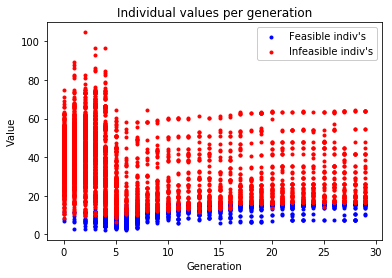

In [19]:
plot_genetic_algorithm_metaheuristic(results, True)

In [20]:
# Imports my plotting module
from batch_plotting import plot_2d_batch_accuracy, plot_3d_batch_accuracy

In [21]:
# Batch testing with population size
pop_size_results = []
for ps in range(20):
    pop_size = 100*(ps+1)
    for i in range(5):
        result = genetic_algorithm(fitness_function, True, DEFAULTS, funcs, population_size=pop_size)
        pop_size_results.append({"x": pop_size, "y": f(result[1]) if result[1] is not False else False})

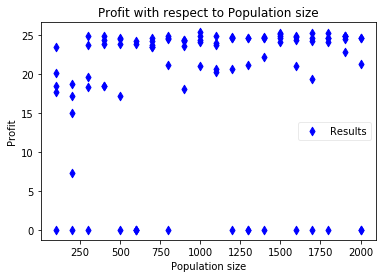

In [22]:
plot_2d_batch_accuracy("Profit", "Population size", False, pop_size_results)

In [23]:
# Change pop size default to 1500 as it seems greater amounts of individuals yields better results, from the last test.
DEFAULTS.population_size = 1500

# Batch testing with fitness upper bound
fub_results = []
for f_u_b in range(20):
    fitness_upper_bound = (f_u_b+1)*0.05
    for i in range(5):
        result = genetic_algorithm(fitness_function, True, DEFAULTS, funcs, fitness_upper_bound=fitness_upper_bound)
        fub_results.append({"x": fitness_upper_bound, "y": f(result[1]) if result[1] is not False else False})

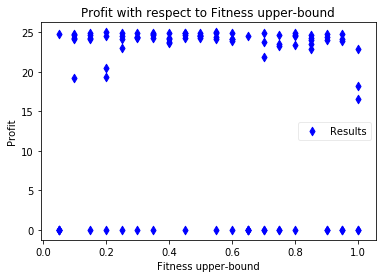

In [24]:
plot_2d_batch_accuracy("Profit", "Fitness upper-bound", False, fub_results)

In [25]:
# Change fitness upper bound to 50% as it seems greater amounts of individuals yields better results, from the last test.
DEFAULTS.fitness_upper_bound = 0.5

# Batch testing with epochs
epoch_results = []
for e in range(5, 41):
    for i in range(5):
        result = genetic_algorithm(fitness_function, True, DEFAULTS, funcs, epochs=e)
        epoch_results.append({"x": e, "y": f(result[1]) if result[1] is not False else False})

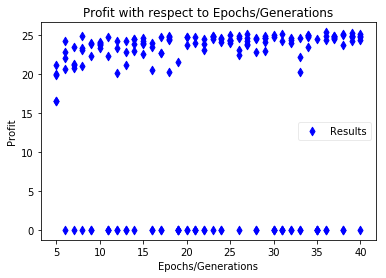

In [26]:
plot_2d_batch_accuracy("Profit", "Epochs/Generations", False, epoch_results)

In [27]:
# The number of epochs of 30 is about right, making things more consistent

# Batch testing with amount of cross over points
start_time = time.time()
coa_results = []
for cross_over_amount in range(5, 21):
    for i in range(4):
        result = genetic_algorithm(fitness_function, True, DEFAULTS, funcs, cross_over_amount=cross_over_amount)
        coa_results.append({"x": cross_over_amount, "y": f(result[1]) if result[1] is not False else False})
end_time = time.time()

In [28]:
print("Execution time: {}s".format(round(end_time-start_time, 3)))

Execution time: 183.16s


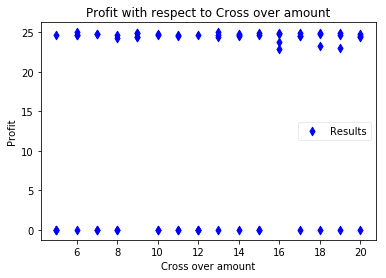

In [29]:
plot_2d_batch_accuracy("Profit", "Cross over amount", False, coa_results)

In [30]:
# A high amount 0f cross over tends to create less meaningful values than low crossover
DEFAULTS.cross_over_amount = 6

# Batch testing with mutation chance
start_time = time.time()
mc_results = []
for mc in range(20):
    mutation_chance = 0.02*(1+mc)
    for i in range(5):
        result = genetic_algorithm(fitness_function, True, DEFAULTS, funcs, mutation_chance=mutation_chance)
        mc_results.append({"x": mutation_chance, "y": f(result[1]) if result[1] is not False else False})
end_time = time.time()
print("Execution time: {}s".format(round(end_time-start_time, 3)))

Execution time: 215.933s


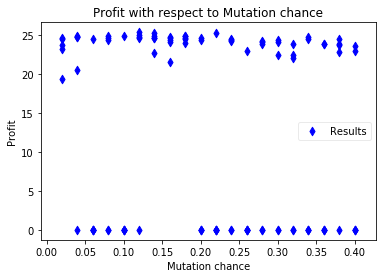

In [31]:
plot_2d_batch_accuracy("Profit", "Mutation chance", False, mc_results)

In [32]:
# Low mutation chance, but not too low (for a bit of diversification) to increase accuracy.
DEFAULTS.mutation_chance = 0.03

def fitness_proportionate_selection(i, population):
    fitnesses = []
    total_fitness = 0 
    for p in population:
        # Changed fitness value into a positive difference from 1000 (highest value in the search space) to make it a maximisation  
        fitness = fitness_function(p.get_value())
        fitnesses.append(fitness)
        total_fitness += fitness
    individuals = []
    for i in range(2):
        random_number = random.random()
        cumulative_probability = fitnesses[0]/total_fitness
        p = 0
        while (cumulative_probability <= random_number):
            p += 1
            cumulative_probability += fitnesses[p]/total_fitness
        individuals.append(population[p])
    return (individuals[0], individuals[1])

def tournament_selection(i, population):
    PROB = 1/3
    individuals = []
    for i in range(2):
        random_number = random.random()
        cumulative_probability = 0
        for p in range(len(population)):
            cumulative_probability += PROB*(1-PROB)**p
            if (random_number < cumulative_probability):
                individuals.append(population[p])
                break
    return (individuals[0], individuals[1])

GA run through, with default (truncation) selection function.
Execution time (Truncation selection GA):  2.118
Feasible:  33393
Infeasible:  11491


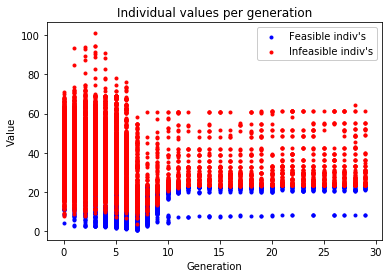

GA run through, with fitness proportionate selection.
Execution time (FPS selection GA):  112.859
Feasible:  35169
Infeasible:  9715


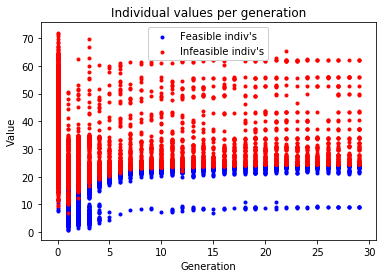

GA run through, with tournament selection; where p=1/3
Execution time (Tournament selection GA):  2.058
Feasible:  40530
Infeasible:  4354


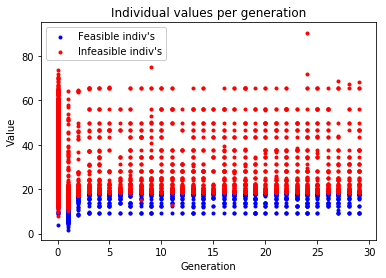

In [33]:
print("GA run through, with default (truncation) selection function.")
start_time = time.time()
trunc_ga_results = genetic_algorithm(fitness_function, True, DEFAULTS, funcs)
end_time = time.time()
print("Execution time (Truncation selection GA): ", round(end_time-start_time, 3))
plot_genetic_algorithm_metaheuristic(trunc_ga_results, True)

print("GA run through, with fitness proportionate selection.")
start_time = time.time()
fps_ga_results = genetic_algorithm(fitness_function, True, DEFAULTS, funcs, selection_function=fitness_proportionate_selection)
end_time = time.time()
print("Execution time (FPS selection GA): ", round(end_time-start_time, 3))
plot_genetic_algorithm_metaheuristic(fps_ga_results, True)

print("GA run through, with tournament selection; where p=1/3")
start_time = time.time()
tourn_ga_results = genetic_algorithm(fitness_function, True, DEFAULTS, funcs, selection_function=tournament_selection)
end_time = time.time()
print("Execution time (Tournament selection GA): ", round(end_time-start_time, 3))
plot_genetic_algorithm_metaheuristic(tourn_ga_results, True)

In [34]:
print_all_constraints(tourn_ga_results[1], constraints)
print("Profit: ", f(tourn_ga_results[1]))
tourn_ga_results[1]

x1 not -ve constraint: 0 <= 0.318
x2 not -ve constraint: 0 <= 2.371
x3 not -ve constraint: 0 <= 1.463
x4 not -ve constraint: 0 <= 0.067
green constraint: 6.59 <= 10
red constraint: 6.0 <= 6
blue constraint: 3.325 <= 10
yellow constraint: 9.802 <= 18
brown constraint: 1.664 <= 8
purple constraint: 4.59 <= 12
Profit:  18.728


{'x1': 0.318, 'x2': 2.371, 'x3': 1.463, 'x4': 0.067}